## DCGAN

우리는 이전 시간에 GAN에 대해 배웠습니다. 학습 데이터들의 분포를 학습해, 같은 분포에서 새로운 데이터를 생성할 수 있도록 DL 모델을 학습시키는 프레임워크를 말합니다.

이번시간에는 GAN이 가지는 불안정성을 일정부분 해소하고 더 나은 성능을 보이는 DCGAN에 대해 알아보겠습니다.

![image](https://www.researchgate.net/publication/331282441/figure/fig3/AS:729118295478273@1550846756282/Deep-convolutional-generative-adversarial-networks-DCGAN-for-generative-model-of-BF-NSP.png)

위의 사진은 DCGAN이 가지는 구조입니다. 전체층이 Convoultion layer로 구성된 모습을 볼 수 있습니다. DCGAN은 위에서 기술한 GAN에서 직접적으로 파생된 모델입니다. 생성자와 구분자에서 합성곱(convolution)과 전치 합성곱(convolution-transpose)을 사용했다는 것이 GAN과의 차이점이라 할 수 있습니다.

DCGAN의 특징과 구현 가이드라인
- max pooling과 같이 미분이 되지 않는 부분을 Convolution으로 대체해서 'all Convolutional net'을 사용
- 주로 사용하던 Fully Connected layers를 제거함
- Batch Normalization을 사용함(Generator의 출력층과 Discriminator의 입력층에는 사용하지 않음)
- ReLU를 사용하고 출력층에만 Tanh(하이퍼볼릭 탄젠트)를 사용
- Discriminator에는 leacky ReLU를 사용

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

# 파일 경로 입력
zip_file_name = '/content/drive/MyDrive/CarCrash_image/train.zip'

# 압축 해제할 경로 입력(드라이브 밖에 폴더로 설정해야함)
extraction_dir = '/content/data'

# 압축 해제
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

In [4]:
cd /content/drive/MyDrive/차량충돌예측/gan

/content/drive/.shortcut-targets-by-id/1m1Hz_Xn7OSUCY1Z2L4Pve8h6mKp1qfiR/차량충돌예측/gan


DiffAugment_pytorch.py 모듈에서 import

In [5]:
from DiffAugment_pytorch import DiffAugment

다음으로 사전에 사용할 데이터와 각종 파라미터들을 설정해주겠습니다.
1. 데이터는 Celeba데이터를 사용합니다.
2. 배치사이즈는 128로 고정하겠습니다.
3. 이미지 사이즈는 64x64 입니다.
4. 컬러RGB이기 떄문에 nc는 3으로 설정합니다.
5. nz는 잠재공간 벡터의 원소개수입니다. 논문에서처럼 100차원으로 설정하였습니다.
6. ngf는 생성자를 통과할떄 만들어지는 특징 데이터 채널개수입니다.
7. ndf는 구분자를 통과할때 만들어지는 특직 데이터의 채널개수입니다.

### 이전 코드

In [6]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 7

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 200

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:
# # We can use an image folder dataset the way we have it setup.
# # Create the dataset
# dataset = dset.ImageFolder(root=dataroot,
#                            transform=transforms.Compose([
#                                transforms.Resize(image_size),
#                                transforms.CenterCrop(image_size),
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                            ]))
# # Create the dataloader
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
#                                          shuffle=True, num_workers=workers)

# # Decide which device we want to run on
# device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

### 변경 중

In [7]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 200

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [8]:
# CSV 파일 불러오기
df = pd.read_csv('/content/drive/MyDrive/CarCrash_image/frame_metadata00.csv')

# label 업데이트
df.loc[df['image_name'].str.contains('TRAIN_2236|TRAIN_2596'), 'label'] = 0
df.loc[df['image_name'].str.contains('TRAIN_0061|TRAIN_0107|TRAIN_0123|TRAIN_0294|TRAIN_0800|TRAIN_1280|TRAIN_1590|TRAIN_2302|TRAIN_2548'), 'label'] = 1
df.loc[df['image_name'].str.contains('TRAIN_0056|TRAIN_0129|TRAIN_0149|TRAIN_0242|TRAIN_0263|TRAIN_0728|TRAIN_0861|TRAIN_0889|TRAIN_0896|TRAIN_0920|TRAIN_1098|TRAIN_1169|TRAIN_1251|TRAIN_1605|TRAIN_1654|TRAIN_1656|TRAIN_1698|TRAIN_1795|TRAIN_1839|TRAIN_1955|TRAIN_2249|TRAIN_2388|TRAIN_2647'), 'label'] = 3
df.loc[df['image_name'].str.contains('TRAIN_0221|TRAIN_0856|TRAIN_1081|TRAIN_1263|TRAIN_1488|TRAIN_1492|TRAIN_1874|TRAIN_2166|TRAIN_2555|TRAIN_2595|TRAIN_2622'), 'label'] = 4
df.loc[df['image_name'].str.contains('TRAIN_0017|TRAIN_0225|TRAIN_0306|TRAIN_1193|TRAIN_1771|TRAIN_1848|TRAIN_2140|TRAIN_2298|TRAIN_2532|TRAIN_2570'), 'label'] = 5
df.loc[df['image_name'].str.contains('TRAIN_0809'), 'label'] = 6
df.loc[df['image_name'].str.contains('TRAIN_0020|TRAIN_0507|TRAIN_0617|TRAIN_1023|TRAIN_1420|TRAIN_1531|TRAIN_2033|TRAIN_2063'), 'label'] = 7
df.loc[df['image_name'].str.contains('TRAIN_0332|TRAIN_0674|TRAIN_0720|TRAIN_0917|TRAIN_1287|TRAIN_1699|TRAIN_1923|TRAIN_1949|TRAIN_2239|TRAIN_2491|TRAIN_2534|TRAIN_2615'), 'label'] = 9
df.loc[df['image_name'].str.contains('TRAIN_0877|TRAIN_1728|TRAIN_2328|TRAIN_2685'), 'label'] = 10
df.loc[df['image_name'].str.contains('TRAIN_0341|TRAIN_1041|TRAIN_1581|TRAIN_1727|TRAIN_2607'), 'label'] = 11
df.loc[df['image_name'].str.contains('TRAIN_2571'), 'label'] = 12

# 삭제할 image_name 리스트 정리
del_list = ['TRAIN_0048', 'TRAIN_0234', 'TRAIN_0238', 'TRAIN_0325', 'TRAIN_0528', 'TRAIN_0554', 'TRAIN_0668',
            'TRAIN_0705', 'TRAIN_0875', 'TRAIN_1082', 'TRAIN_1151', 'TRAIN_1337', 'TRAIN_1362', 'TRAIN_1506',
            'TRAIN_1674', 'TRAIN_1681', 'TRAIN_1753', 'TRAIN_1838', 'TRAIN_2191', 'TRAIN_2356', 'TRAIN_2360',
            'TRAIN_2428', 'TRAIN_2451', 'TRAIN_2486', 'TRAIN_2558', 'TRAIN_2658']

# image_name 목록에 있는 행 삭제
pattern = '|'.join(del_list)
df = df[~df['image_name'].str.contains(pattern)]
df = df[df['label'] != 0]
# 데이터프레임 크기 확인
print(df.shape)

(44400, 3)


In [9]:
# 경로 변경 함수 정의
def update_path(old_path):
    return old_path.replace('/content/drive/MyDrive/my_data/CarCrash_image/train00', '/content/data/train')

# image_path 열의 값 변경
df['image_path'] = df['image_path'].apply(update_path)
df.head(2)

,image_name,image_path,label
0,TRAIN_0000_frame_0000.jpg,/content/data/train/TRAIN_0000_frame_0000.jpg,7
1,TRAIN_0000_frame_0001.jpg,/content/data/train/TRAIN_0000_frame_0001.jpg,7


In [10]:
frames_list = ['frame_0000', 'frame_0025', 'frame_0049']
df = df[df['image_name'].apply(lambda x: any(x.endswith(frame + '.jpg') for frame in frames_list))]
df.shape

(2664, 3)

### weather에 대한 라벨 변경

In [11]:
# normal
df.loc[df['label'].isin([1, 2, 7, 8]), 'label'] = 0

# snowy
df.loc[df['label'].isin([3, 4, 9, 10]), 'label'] = 1

# rainy
df.loc[df['label'].isin([5, 6, 11, 12]), 'label'] = 2

df['label'].value_counts()

label
0    1902
1     513
2     249
Name: count, dtype: int64

In [12]:
df_2 = df[df['label']==0]

In [13]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(manualSeed) # Seed 고정

In [ ]:
import cv2
from PIL import Image
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, image_path_list, transform=None):
        self.image_path_list = image_path_list
        self.transform = transform

    def __getitem__(self, index):
        img_path = self.image_path_list[index]
        image = self.get_image(img_path)
        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.image_path_list)

    def get_image(self, path):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # RGB로 변환
        return Image.fromarray(img)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋과 데이터로더 생성
dataset = CustomDataset(df_2['image_path'].values, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)

DCGAN논문에서 평균이 0이며 분산이 0.02인 정규분포를 이용해서 구분자와 생성자 모두를 무작위 초기화 진행하는것이 좋다고 이야기합니다.

weights_init함수를 정의해 모든 합성곱 계층과 전치 합성곱 계층, 배치 정규화 계층의 가중치를 초기화합니다.

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Model

다음은 Generator와 Discriminator를 정의하는 부분입니다.

Discriminator 모델에서 흔히 딥러닝 모델에 쓰는 ReLU 대신 Leaky ReLU 함수를 쓰는 것일까요? 그 이유에 대해 알아보기 전, 자주 쓰이는 활성화 함수 네 가지를 정리해 보겠습니다.

* 시그모이드

output값을 0에서 1 사이로 만들어 주는 비선형 함수입니다.
input값이 너무 크거나 작아지면 기울기가 거의 0이 되는 gradient vanishing 현상이 나타날 수 있습니다.

* Tanh (하이퍼볼릭탄젠트)

시그모이드와 유사하나, -1에서 1 사이의 값을 가집니다. 그렇기 때문에 시그모이드보다 대부분의 경우 학습이 더 잘 이루어집니다.
그러나 시그모이드와 마찬가지로 gradient vanishing 현상이 발생할 수 있습니다.

그렇다면 gradient vanishing 현상이란 무엇일까요?

Gradient Vanishing 현상이란, MLP를 학습시키는 방법인 역전파 (Backpropagation) 중 Gradient항이 사라지는 현상을 말합니다.
이 항이 0이 되거나 0에 가까워져서 학습이 불가능해지는 현상인데요!
이를 해결하기 위해 딥러닝에서는 ReLu 함수를 가장 많이 사용합니다.

* ReLU

ReLU 함수는 x값이 양수면 미분값이 1이 되고, x값이 음수면 미분값이 0이 되는 활성화 함수입니다.
앞의 두 활성화 함수와 달리 대부분의 input 값에 대해 기울기가 0이 되는 것을 방지하는 함수입니다.
그렇기 때문에 학습이 매우 빠른 편입니다.
하지만 x가 음수일 때 미분값이 0이 되는 현상, 즉 Dead ReLU 현상이 발생할 수 있는데요!

이를 보완한 활성화 함수가 바로 Leaky ReLU 함수입니다.
x가 음수일 때 미분값이 0이 되는 것이 아닌 약간의 기울기값을 갖게 하여 Dead ReLU 현상을 보완할 수 있습니다.

### Generator

In [ ]:
# # Generator Code

# class Generator(nn.Module):
#     def __init__(self, ngpu):
#         super(Generator, self).__init__()
#         self.ngpu = ngpu
#         self.main = nn.Sequential(
#             # input is Z, going into a convolution
#             nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
#             nn.BatchNorm2d(ngf * 8),
#             nn.ReLU(True),
#             # state size. (ngf*8) x 4 x 4
#             nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 4),
#             nn.ReLU(True),
#             # state size. (ngf*4) x 8 x 8
#             nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 2),
#             nn.ReLU(True),
#             # state size. (ngf*2) x 16 x 16
#             nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf),
#             nn.ReLU(True),
#             # state size. (ngf) x 32 x 32
#             nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
#             nn.Tanh()
#             # state size. (nc) x 64 x 64
#         )

#     def forward(self, input):
#         return self.main(input)

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.ReLU(True),
            # state size. (nc) x 64 x 64
            nn.ConvTranspose2d( nc, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 128 x 128
        )

    def forward(self, input):
        return self.main(input)

Generator를 구현했습니다. Generator는 앞에서 설명했던 내용처럼 전치 합성곱층으로만 구성되어있고, 각각 Batch Norm을 수행합니다. 활성화함수로는 ReLU를 사용합니다.

Generator의 ConvTranspose2d는 아마 처음 보시는 분들이 많을 것 같습니다.

일반적으로 Conv Layer는 곱연산을 통해서 output size를 줄여나가는 방식으로 계산을 합니다.

$OutputSize = [(InputSize - Kernel + 2*Padding)/Stride] + 1$

그러나 ConvTranspose는 반대로 곱연산을 통해서 output size를 늘려나가는 방식입니다.

$OutputSize = (InputSize - 1)*Stride - 2*Padding + (Kernel - 1) + 1$



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): ReLU(inplace=

### Discriminator

In [ ]:
# class Discriminator(nn.Module):
#     def __init__(self, ngpu):
#         super(Discriminator, self).__init__()
#         self.ngpu = ngpu
#         self.main = nn.Sequential(
#             # input is (nc) x 64 x 64
#             nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf) x 32 x 32
#             nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 2),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*2) x 16 x 16
#             nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*4) x 8 x 8
#             nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 8),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*8) x 4 x 4
#             nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid()
#         )

#     def forward(self, input):
#         return self.main(input)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # input is (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf*2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

다음으로 Discriminator를 구현했습니다. Conv층으로 구성되어있고, LeaktReLU를 사용합니다.입력층과 출력층을 제외하고 Batch Norm이 추가되어있는것을 확인해볼 수 있습니다.

위의 설명대로 pooling layer를 이용하지 않고, 오로지 conv layer 내의 kernel size와 stride만을 이용하여 output size를 줄여나가는 것을 확인할 수 있습니다.

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0

이로써 Generator와 Discriminator를 정의하였습니다.

### Train

Loss와 optimizer를 마저 설정하고 학습을 진행하도록 하겠습니다.

학습이 진행되는 코드는 이전 포스팅의 GAN의 코드와 동일합니다.

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(16, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# DiffAugment
policy = 'color,translation,cutout'

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(tqdm(dataloader)):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        # output = netD(real_cpu).view(-1)
        output = netD(DiffAugment(real_cpu, policy=policy)).view(-1) # 추가

        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)

        label.fill_(fake_label)
        # Classify all fake batch with D
        # output = netD(fake.detach()).view(-1)
        output = netD(DiffAugment(fake.detach(), policy=policy)).view(-1)  # 추가
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        # output = netD(fake).view(-1)
        output = netD(DiffAugment(fake, policy=policy)).view(-1)

        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    # Output training stats
    print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
            % (epoch, num_epochs,errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    # Save Losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())

Starting Training Loop...


100%|██████████| 119/119 [00:30<00:00,  3.92it/s]


[0/200]	Loss_D: 0.1884	Loss_G: 3.2638	D(x): 0.9860	D(G(z)): 0.1525 / 0.0760


100%|██████████| 119/119 [00:30<00:00,  3.89it/s]


[1/200]	Loss_D: 0.1668	Loss_G: 0.3506	D(x): 0.8665	D(G(z)): 0.0230 / 0.7055


100%|██████████| 119/119 [00:30<00:00,  3.92it/s]


[2/200]	Loss_D: 0.8502	Loss_G: 0.7036	D(x): 0.5574	D(G(z)): 0.1150 / 0.5020


100%|██████████| 119/119 [00:29<00:00,  3.97it/s]


[3/200]	Loss_D: 1.8423	Loss_G: 0.4851	D(x): 0.3646	D(G(z)): 0.3881 / 0.6445


100%|██████████| 119/119 [00:30<00:00,  3.95it/s]


[4/200]	Loss_D: 1.0950	Loss_G: 3.4386	D(x): 0.9893	D(G(z)): 0.5468 / 0.0912


100%|██████████| 119/119 [00:30<00:00,  3.95it/s]


[5/200]	Loss_D: 0.1225	Loss_G: 3.7619	D(x): 0.9898	D(G(z)): 0.1051 / 0.0485


100%|██████████| 119/119 [00:30<00:00,  3.96it/s]


[6/200]	Loss_D: 0.7390	Loss_G: 1.7051	D(x): 0.5862	D(G(z)): 0.1776 / 0.2009


100%|██████████| 119/119 [00:29<00:00,  3.97it/s]


[7/200]	Loss_D: 0.7835	Loss_G: 0.9619	D(x): 0.6067	D(G(z)): 0.0632 / 0.4521


100%|██████████| 119/119 [00:29<00:00,  3.97it/s]


[8/200]	Loss_D: 0.5909	Loss_G: 2.4434	D(x): 0.6252	D(G(z)): 0.0684 / 0.1016


100%|██████████| 119/119 [00:30<00:00,  3.97it/s]


[9/200]	Loss_D: 1.0991	Loss_G: 4.1780	D(x): 0.5107	D(G(z)): 0.0058 / 0.0186


100%|██████████| 119/119 [00:30<00:00,  3.95it/s]


[10/200]	Loss_D: 0.6584	Loss_G: 4.4734	D(x): 0.8028	D(G(z)): 0.3487 / 0.0714


100%|██████████| 119/119 [00:30<00:00,  3.95it/s]


[11/200]	Loss_D: 0.5477	Loss_G: 2.0787	D(x): 0.9480	D(G(z)): 0.3358 / 0.1615


100%|██████████| 119/119 [00:30<00:00,  3.96it/s]


[12/200]	Loss_D: 3.1944	Loss_G: 1.7085	D(x): 0.4771	D(G(z)): 0.8310 / 0.2559


100%|██████████| 119/119 [00:30<00:00,  3.93it/s]


[13/200]	Loss_D: 0.6274	Loss_G: 1.6617	D(x): 0.9423	D(G(z)): 0.4128 / 0.3326


100%|██████████| 119/119 [00:29<00:00,  3.97it/s]


[14/200]	Loss_D: 1.4169	Loss_G: 3.3031	D(x): 0.6353	D(G(z)): 0.5177 / 0.0815


100%|██████████| 119/119 [00:30<00:00,  3.96it/s]


[15/200]	Loss_D: 0.0400	Loss_G: 6.0050	D(x): 0.9798	D(G(z)): 0.0189 / 0.0029


100%|██████████| 119/119 [00:29<00:00,  3.97it/s]


[16/200]	Loss_D: 0.6525	Loss_G: 1.1278	D(x): 0.6856	D(G(z)): 0.2132 / 0.3832


100%|██████████| 119/119 [00:30<00:00,  3.96it/s]


[17/200]	Loss_D: 0.8130	Loss_G: 2.3066	D(x): 0.5325	D(G(z)): 0.1402 / 0.1642


100%|██████████| 119/119 [00:30<00:00,  3.96it/s]


[18/200]	Loss_D: 2.4127	Loss_G: 2.5308	D(x): 0.3271	D(G(z)): 0.6420 / 0.1535


100%|██████████| 119/119 [00:30<00:00,  3.94it/s]


[19/200]	Loss_D: 1.2566	Loss_G: 4.0489	D(x): 0.3218	D(G(z)): 0.0023 / 0.0641


100%|██████████| 119/119 [00:29<00:00,  3.97it/s]


[20/200]	Loss_D: 0.2729	Loss_G: 3.7668	D(x): 0.9439	D(G(z)): 0.1837 / 0.0357


100%|██████████| 119/119 [00:30<00:00,  3.96it/s]


[21/200]	Loss_D: 1.1341	Loss_G: 1.1188	D(x): 0.3646	D(G(z)): 0.0999 / 0.3731


100%|██████████| 119/119 [00:30<00:00,  3.94it/s]


[22/200]	Loss_D: 0.2979	Loss_G: 3.6793	D(x): 0.8515	D(G(z)): 0.1122 / 0.0323


100%|██████████| 119/119 [00:30<00:00,  3.95it/s]


[23/200]	Loss_D: 0.6402	Loss_G: 2.9899	D(x): 0.6770	D(G(z)): 0.0314 / 0.0834


100%|██████████| 119/119 [00:30<00:00,  3.94it/s]


[24/200]	Loss_D: 1.5816	Loss_G: 3.8839	D(x): 0.9990	D(G(z)): 0.7304 / 0.1107


100%|██████████| 119/119 [00:29<00:00,  3.97it/s]


[25/200]	Loss_D: 0.3197	Loss_G: 1.3609	D(x): 0.8363	D(G(z)): 0.1251 / 0.2766


100%|██████████| 119/119 [00:30<00:00,  3.96it/s]


[26/200]	Loss_D: 2.9552	Loss_G: 2.9578	D(x): 0.1607	D(G(z)): 0.4819 / 0.0609


100%|██████████| 119/119 [00:29<00:00,  3.97it/s]


[27/200]	Loss_D: 0.6116	Loss_G: 1.1357	D(x): 0.9998	D(G(z)): 0.4084 / 0.4889


100%|██████████| 119/119 [00:30<00:00,  3.95it/s]


[28/200]	Loss_D: 0.4597	Loss_G: 1.5415	D(x): 0.9228	D(G(z)): 0.2926 / 0.2295


100%|██████████| 119/119 [00:30<00:00,  3.94it/s]


[29/200]	Loss_D: 0.6177	Loss_G: 1.4190	D(x): 0.9954	D(G(z)): 0.4116 / 0.4869


100%|██████████| 119/119 [00:30<00:00,  3.96it/s]


[30/200]	Loss_D: 0.4507	Loss_G: 2.5578	D(x): 0.9604	D(G(z)): 0.3128 / 0.0811


100%|██████████| 119/119 [00:30<00:00,  3.89it/s]


[31/200]	Loss_D: 0.7547	Loss_G: 1.8167	D(x): 0.4891	D(G(z)): 0.0168 / 0.1694


100%|██████████| 119/119 [00:30<00:00,  3.92it/s]


[32/200]	Loss_D: 0.1794	Loss_G: 0.7760	D(x): 0.9048	D(G(z)): 0.0736 / 0.4640


100%|██████████| 119/119 [00:30<00:00,  3.95it/s]


[33/200]	Loss_D: 0.0026	Loss_G: 4.6890	D(x): 0.9999	D(G(z)): 0.0024 / 0.0384


100%|██████████| 119/119 [00:29<00:00,  3.99it/s]


[34/200]	Loss_D: 0.6327	Loss_G: 2.7808	D(x): 0.7689	D(G(z)): 0.3018 / 0.1158


100%|██████████| 119/119 [00:30<00:00,  3.95it/s]


[35/200]	Loss_D: 0.1470	Loss_G: 4.4369	D(x): 0.9908	D(G(z)): 0.1282 / 0.0254


100%|██████████| 119/119 [00:30<00:00,  3.91it/s]


[36/200]	Loss_D: 0.0348	Loss_G: 5.7293	D(x): 0.9999	D(G(z)): 0.0340 / 0.0051


100%|██████████| 119/119 [00:30<00:00,  3.90it/s]


[37/200]	Loss_D: 0.6742	Loss_G: 2.5492	D(x): 0.5469	D(G(z)): 0.0159 / 0.0951


100%|██████████| 119/119 [00:30<00:00,  3.91it/s]


[38/200]	Loss_D: 0.6788	Loss_G: 1.4897	D(x): 1.0000	D(G(z)): 0.4610 / 0.2429


100%|██████████| 119/119 [00:30<00:00,  3.90it/s]


[39/200]	Loss_D: 0.3527	Loss_G: 2.4897	D(x): 0.9849	D(G(z)): 0.2239 / 0.3191


100%|██████████| 119/119 [00:30<00:00,  3.89it/s]


[40/200]	Loss_D: 0.5666	Loss_G: 2.8238	D(x): 0.8741	D(G(z)): 0.3317 / 0.0661


100%|██████████| 119/119 [00:30<00:00,  3.92it/s]


[41/200]	Loss_D: 1.9224	Loss_G: 2.0417	D(x): 0.4088	D(G(z)): 0.5693 / 0.1392


100%|██████████| 119/119 [00:30<00:00,  3.90it/s]


[42/200]	Loss_D: 0.1574	Loss_G: 4.3078	D(x): 0.9859	D(G(z)): 0.1269 / 0.0210


100%|██████████| 119/119 [00:30<00:00,  3.92it/s]


[43/200]	Loss_D: 0.5576	Loss_G: 0.6190	D(x): 0.8718	D(G(z)): 0.2827 / 0.5495


100%|██████████| 119/119 [00:30<00:00,  3.93it/s]


[44/200]	Loss_D: 0.0601	Loss_G: 1.6875	D(x): 0.9781	D(G(z)): 0.0365 / 0.1998


100%|██████████| 119/119 [00:30<00:00,  3.93it/s]


[45/200]	Loss_D: 0.0336	Loss_G: 3.3992	D(x): 0.9880	D(G(z)): 0.0213 / 0.0520


100%|██████████| 119/119 [00:30<00:00,  3.90it/s]


[46/200]	Loss_D: 1.0651	Loss_G: 0.7188	D(x): 0.3790	D(G(z)): 0.0021 / 0.6097


100%|██████████| 119/119 [00:30<00:00,  3.90it/s]


[47/200]	Loss_D: 0.1240	Loss_G: 4.4802	D(x): 0.9352	D(G(z)): 0.0538 / 0.0169


100%|██████████| 119/119 [00:30<00:00,  3.86it/s]


[48/200]	Loss_D: 0.2025	Loss_G: 2.7730	D(x): 1.0000	D(G(z)): 0.1713 / 0.0656


100%|██████████| 119/119 [00:30<00:00,  3.94it/s]


[49/200]	Loss_D: 0.3217	Loss_G: 3.4225	D(x): 0.7613	D(G(z)): 0.0154 / 0.0502


100%|██████████| 119/119 [00:30<00:00,  3.94it/s]


[50/200]	Loss_D: 0.3380	Loss_G: 3.0461	D(x): 0.7637	D(G(z)): 0.0405 / 0.0760


100%|██████████| 119/119 [00:30<00:00,  3.96it/s]


[51/200]	Loss_D: 0.2463	Loss_G: 2.1822	D(x): 0.7952	D(G(z)): 0.0154 / 0.1231


100%|██████████| 119/119 [00:30<00:00,  3.96it/s]


[52/200]	Loss_D: 1.1942	Loss_G: 4.8251	D(x): 0.9916	D(G(z)): 0.5384 / 0.0153


100%|██████████| 119/119 [00:30<00:00,  3.94it/s]


[53/200]	Loss_D: 0.1751	Loss_G: 4.4535	D(x): 0.9288	D(G(z)): 0.0926 / 0.0230


100%|██████████| 119/119 [00:30<00:00,  3.96it/s]


[54/200]	Loss_D: 0.4927	Loss_G: 3.1880	D(x): 0.9937	D(G(z)): 0.3509 / 0.0539


100%|██████████| 119/119 [00:30<00:00,  3.94it/s]


[55/200]	Loss_D: 0.0551	Loss_G: 3.5580	D(x): 1.0000	D(G(z)): 0.0524 / 0.0348


100%|██████████| 119/119 [00:30<00:00,  3.95it/s]


[56/200]	Loss_D: 0.3757	Loss_G: 1.8116	D(x): 0.8532	D(G(z)): 0.1626 / 0.1828


100%|██████████| 119/119 [00:30<00:00,  3.93it/s]


[57/200]	Loss_D: 1.1220	Loss_G: 2.0020	D(x): 0.9021	D(G(z)): 0.5165 / 0.1622


100%|██████████| 119/119 [00:30<00:00,  3.92it/s]


[58/200]	Loss_D: 2.1830	Loss_G: 5.3141	D(x): 0.1830	D(G(z)): 0.0008 / 0.0077


100%|██████████| 119/119 [00:30<00:00,  3.94it/s]


[59/200]	Loss_D: 0.0794	Loss_G: 7.6043	D(x): 0.9304	D(G(z)): 0.0071 / 0.0007


100%|██████████| 119/119 [00:29<00:00,  3.97it/s]


[60/200]	Loss_D: 2.5454	Loss_G: 2.8655	D(x): 0.2836	D(G(z)): 0.0195 / 0.0577


100%|██████████| 119/119 [00:30<00:00,  3.96it/s]


[61/200]	Loss_D: 1.4848	Loss_G: 4.1566	D(x): 0.9294	D(G(z)): 0.6793 / 0.0425


 82%|████████▏ | 98/119 [00:24<00:05,  3.89it/s]

### Result

학습이 완료되었습니다!  이제 DCGAN이 얼마나 이미지를 잘 생성했는지 확인해 보도록 하겠습니다.

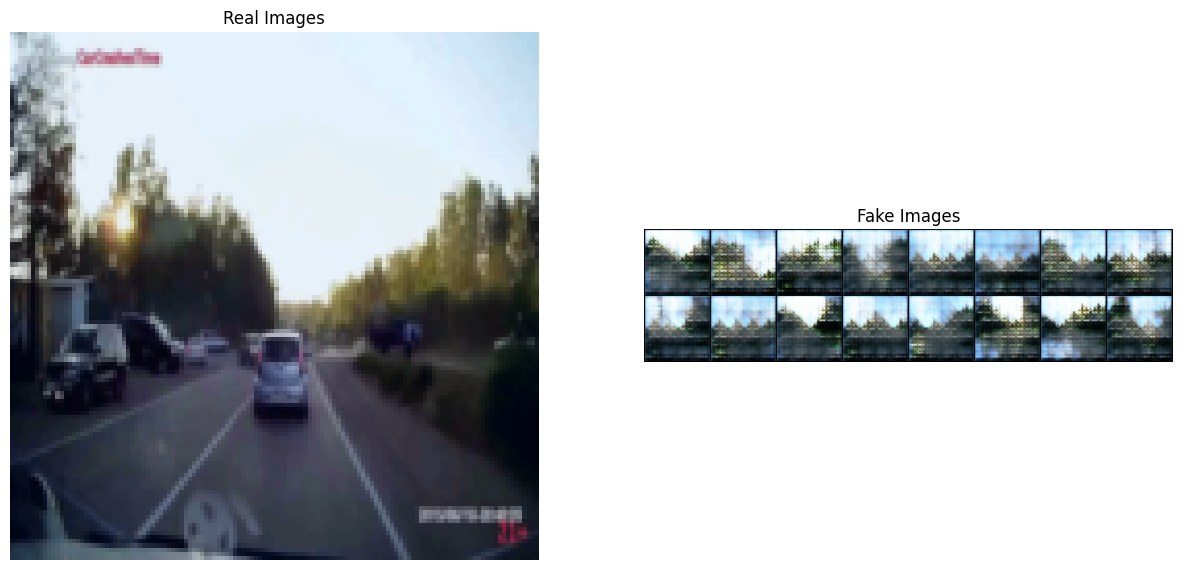

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

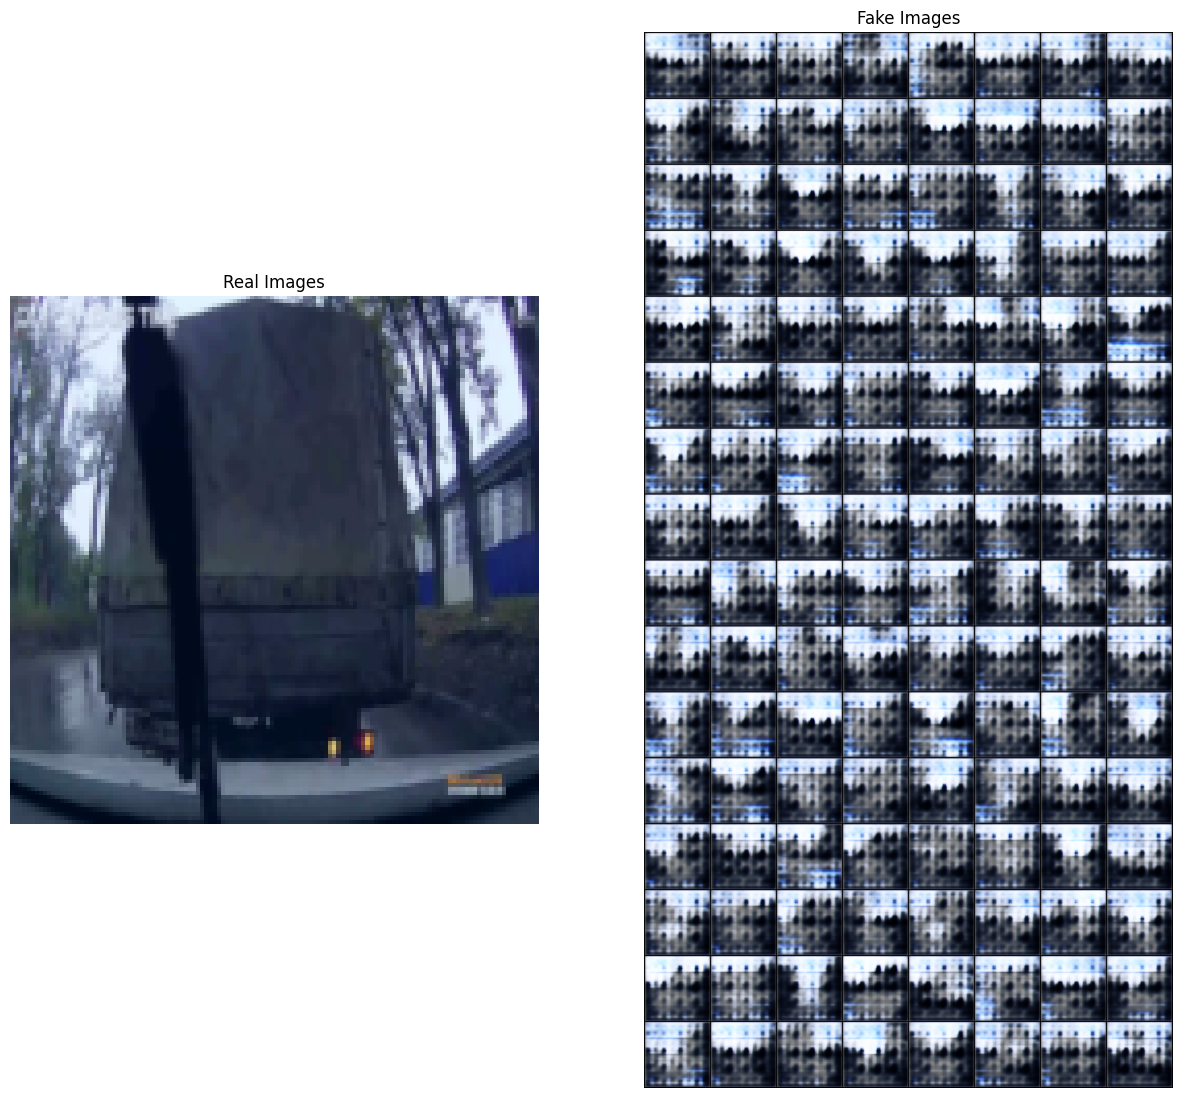

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

---

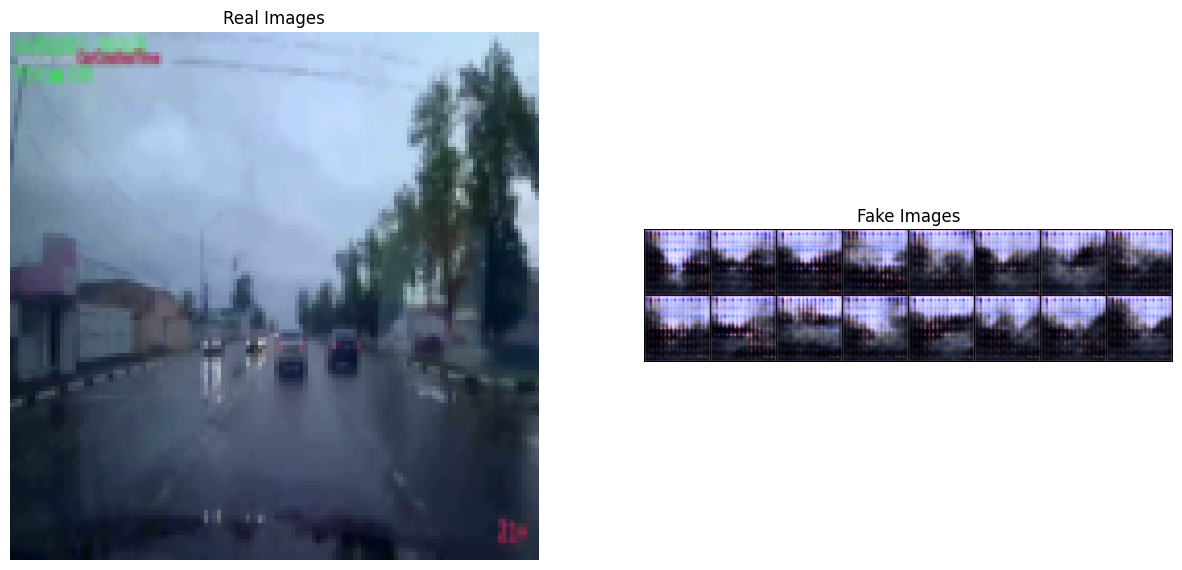

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

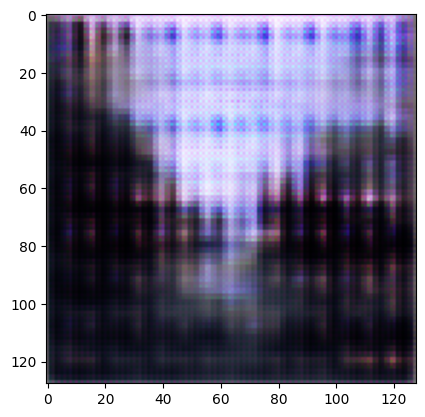

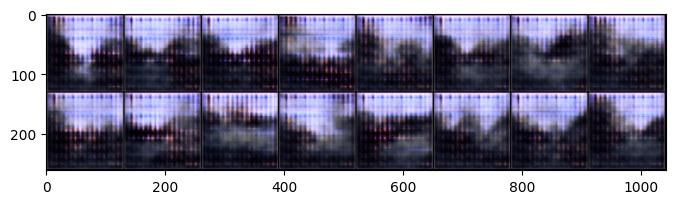

In [ ]:
# netG(fixed_noise).detach().cpu()
fake_images = netG(fixed_noise).detach().cpu()

# 이미지 시각화 함수
def imshow(img):
    img = img / 2 + 0.5  # Normalize to [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 배치 중 첫 번째 이미지 시각화
imshow(fake_images[0])

# 여러 이미지 시각화
grid_img = vutils.make_grid(fake_images[:16], padding=2, normalize=True)
# img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
plt.figure(figsize=(8, 8))
plt.imshow(np.transpose(grid_img.cpu(), (1, 2, 0)))
plt.show()

### 마치며

이번시간에는 DCGAN에 대해 알아보았습니다.

- DCGAN은 convolution layer만을 이용하여 실제 이미지와 유사한 rgb의 이미지를 생성해내는 것을 확인할 수 있었습니다.
- 이미지 사이즈가 커질때마다 층을 추가해주어 더 나은 성능을 기대할 수 있는 것을 확인했습니다. 층깊이를 더 키워보면 좋았을 아쉬움이 남습니다.
- 학습시간이 오래걸려 더 많은 에포크의 학습을 진행하지 못한 부분이 아쉬웠습니다. (추후 학습시간을 늘려서 진행해보고자 합니다.
- GAN이 가지는 불안정성에 정면으로 도전장을 내민 DCGAN 보다 완벽한 이미지를 생성해낼 수 있는 것을 보면 기술의 발전은 무궁무진하다는 생각이 드는 시간이였습니다.

### Reference

- DCGAN paper - Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks: https://arxiv.org/abs/1511.06434
- CelebA: https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
- DCGAN pytorch tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html